In [214]:
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import pandas as pd
import yfinance as yf
from scipy.stats import norm
from tabulate import tabulate

### Timeframe

In [215]:
years = 15

end_date = dt.datetime.now()
start_date = end_date - dt.timedelta(days=365 * years)

### Securities to put into portfolio

In [216]:
tickers = [
    "UNG",
    "GLD",
    "UCO",
    "BNO",
    "COCO.L",
]  # Natural Gas, Gold, Crude Oil, Brent Crude, Cocoa Beans ETFs

In [217]:
adj_closed_df = pd.DataFrame()

for i in tickers:
    adj_closed_df[i] = yf.download(i, start=start_date, end=end_date)["Adj Close"]

print(adj_closed_df)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
                   UNG         GLD          UCO        BNO  COCO.L
Date                                                              
2009-01-22  616.000000   84.580002  2770.000000        NaN     NaN
2009-01-23  591.679993   88.529999  3182.500000        NaN     NaN
2009-01-26  589.119995   88.949997  3150.000000        NaN     NaN
2009-01-27  587.200012   88.379997  2650.000000        NaN     NaN
2009-01-28  588.479980   87.419998  2675.000000        NaN     NaN
...                ...         ...          ...        ...     ...
2024-01-12    6.820000  189.710007    26.879999  27.900000  4.2820
2024-01-16    5.780000  187.910004    26.200001  27.

### Calculate log returns and remove NaNs

In [218]:
log_returns = np.log(adj_closed_df / adj_closed_df.shift(1))
log_returns = log_returns.dropna()
log_returns

,UNG,GLD,UCO,BNO,COCO.L
Date,,,,,
2010-06-03,0.059143,-0.015311,0.023603,0.009335,0.004963
2010-06-04,0.021001,0.010373,-0.092373,-0.044733,-0.027605
2010-06-07,0.026539,0.019113,-0.006696,0.003839,-0.010230
2010-06-08,-0.026539,-0.004041,0.031959,-0.004244,0.007682
2010-06-09,-0.024754,-0.003643,0.045583,0.025591,0.007624
...,...,...,...,...,...
2024-01-12,0.080898,0.009746,0.012729,0.007194,0.016720
2024-01-16,-0.165456,-0.009533,-0.025623,-0.007194,0.014260
2024-01-17,0.006897,-0.011077,0.013647,0.003604,0.005281


### Create Equally Weighted Portfolio and finding Historical Portfolio Returns

In [219]:
portfolio_value = 1000000  # 1 million USD
weighting = np.array([1 / len(tickers)] * len(tickers))
weighting

array([0.2, 0.2, 0.2, 0.2, 0.2])

In [220]:
historical_returns = (log_returns * weighting).sum(axis=1)
historical_returns

Date
2010-06-03    0.016347
2010-06-04   -0.026667
2010-06-07    0.006513
2010-06-08    0.000963
2010-06-09    0.010080
                ...   
2024-01-12    0.025458
2024-01-16   -0.038709
2024-01-17    0.003670
2024-01-18    0.001139
2024-01-19    0.004482
Length: 3307, dtype: float64

In [221]:
# Find X-day historical returns

days = 5

historical_returns_x_days = historical_returns.rolling(window=days).sum()
historical_returns_x_days.dropna()

Date
2010-06-09    0.007236
2010-06-10   -0.001323
2010-06-11    0.024493
2010-06-14    0.028051
2010-06-15    0.048749
                ...   
2024-01-12    0.032350
2024-01-16    0.015320
2024-01-17   -0.007919
2024-01-18    0.008551
2024-01-19   -0.003960
Length: 3303, dtype: float64

# Parametric

### Create covariance matrix

In [222]:
covariance = log_returns.cov() * 252  # stock market open for 252 days of the year

### Calculate portfolio standard deviation

In [223]:
portfolio_std_dev = np.sqrt(weighting.T @ covariance @ weighting)

### Calculating VaR at different confidence levels and seeing the effect on VaR

In [224]:
from scipy.stats import norm

confidence_levels = [0.90, 0.95, 0.99]

VaRs = []
for cl in confidence_levels:
    VaR = portfolio_value * (
        norm.ppf(1 - cl) * portfolio_std_dev * np.sqrt(days / 252)
        - historical_returns.mean() * days
    )
    VaRs.append(VaR)

In [225]:
print(f'{"Confidence Level":<20} {"Value at Risk":<20}')
print("-" * 40)

for cl, VaR in zip(confidence_levels, VaRs):
    print(f'{cl * 100:>6.0f}%: {"":<8} ${VaR:>10,.2f}')

Confidence Level     Value at Risk       
----------------------------------------
    90%:          $-44,871.15
    95%:          $-58,247.89
    99%:          $-83,340.42


### Plotting

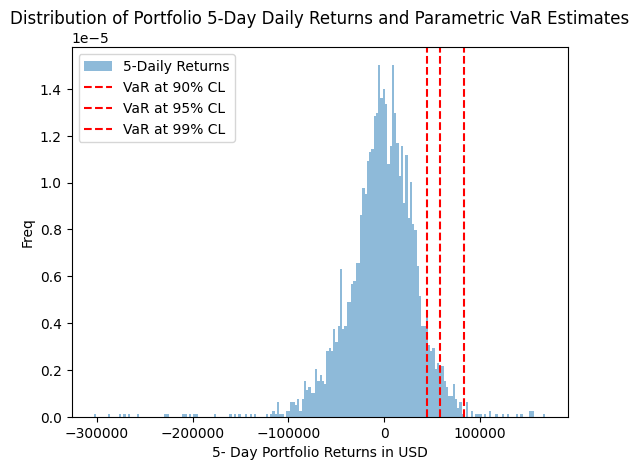

In [226]:
historical_x_day = historical_returns_x_days * portfolio_value

plt.hist(
    historical_x_day, bins=200, density=True, alpha=0.5, label=f"{days}-Daily Returns"
)

for j, VaR in zip(confidence_levels, VaRs):
    plt.axvline(
        x=-VaR, linestyle="--", color="r", label="VaR at {}% CL".format(int(j * 100))
    )

plt.xlabel(f"{days}- Day Portfolio Returns in USD")
plt.ylabel("Freq")
plt.title(
    f"Distribution of Portfolio {days}-Day Daily Returns and Parametric VaR Estimates"
)
plt.legend()
plt.show()

# Historical

### Calculating VaR at 95% level of confidence

In [227]:
days = 5

historical_returns_x_days = historical_returns.rolling(window=days).sum()
historical_returns_x_days = historical_returns_x_days.dropna()
print(historical_returns_x_days)

Date
2010-06-09    0.007236
2010-06-10   -0.001323
2010-06-11    0.024493
2010-06-14    0.028051
2010-06-15    0.048749
                ...   
2024-01-12    0.032350
2024-01-16    0.015320
2024-01-17   -0.007919
2024-01-18    0.008551
2024-01-19   -0.003960
Length: 3303, dtype: float64


In [228]:
confidence = 0.95

VaR = (
    -np.percentile(historical_returns_x_days, 100 - (confidence * 100))
    * portfolio_value
)
VaR

62359.261390165106

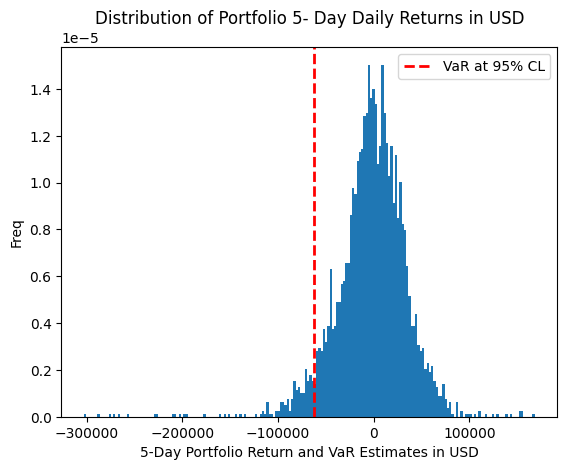

In [229]:
historical_returns_x_ = historical_returns_x_days * portfolio_value

plt.hist(historical_returns_x_.dropna(), bins=200, density=True)
plt.xlabel(f"{days}-Day Portfolio Return and VaR Estimates in USD")
plt.ylabel("Freq")
plt.title(f"Distribution of Portfolio {days}- Day Daily Returns in USD")
plt.axvline(
    -VaR,
    color="r",
    linestyle="dashed",
    linewidth=2,
    label=f"VaR at {confidence:.0%} CL",
)
plt.legend()
plt.show()